In [ ]:
# Import libraries
from bs4 import BeautifulSoup
import pandas as pd
import os
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Initialize dictionary to store HTML tables
html_tables = {}

# For every file in the datasets folder...
for table_name in os.listdir('/content/'):
    # This is the path to the file. Don't touch!
    table_path = f'/content/{table_name}'
    # Check if the table_name is a file
    if os.path.isfile(table_path):
        # Open the file and read its contents
        with open(table_path, 'r') as table_file:
            # Parse the HTML using BeautifulSoup
            html = BeautifulSoup(table_file, 'html.parser')
            # Find 'news-table' in the Soup and load it into 'html_table'
            html_table = html.find(id="news-table")
            # Add the table to the dictionary
            html_tables[table_name] = html_table

In [ ]:
# Extract headlines from a single day (example: tsla_22sep.html)
tsla = html_tables['tsla_22sep.html']
# Get all the table rows tagged in HTML with <tr>
tsla_tr = tsla.findAll('tr')

# Iterate through the table rows and print link_text and data_text
for i, table_row in enumerate(tsla_tr):
    link_text = table_row.a.get_text()
    data_text = table_row.td.get_text()
    print(f'{i}:')
    print(link_text)
    print(data_text)

    # Exit the loop after three rows to prevent spamming the notebook
    if i == 3:
        break

0:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
1:
Broadcoms Stock Looks Like a Winner
09:30PM  
2:
SHAREHOLDER ALERT:  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
3:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


In [ ]:
# Initialize list to hold parsed news
parsed_news = []

# Iterate through the news tables
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text()
        headline = x.a.get_text()
        # Split the text in the td tag into a list
        date_scrape = x.td.text.split()
        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'
        ticker = file_name.split('_')[0]
        # Append ticker, date, time, and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, headline])

In [ ]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Update the lexicon with new words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
vader.lexicon.update(new_words)

In [ ]:
# Convert the list of lists into a DataFrame
columns = ['ticker', 'date', 'time', 'headline']
scored_news = pd.DataFrame(parsed_news, columns=columns)

In [ ]:
# Calculate polarity scores for each headline
scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]
scores_df = pd.DataFrame(scores)

In [ ]:
# Join the DataFrames
scored_news = pd.concat([scored_news, scores_df], axis=1)

In [ ]:
scored_news

,ticker,date,time,headline,neg,neu,pos,compound
0,tsla,Sep-21-18,09:56PM,Billionaire investor questions Elon Musk getti...,0.000,1.000,0.000,0.0000
1,tsla,Sep-21-18,09:30PM,Broadcoms Stock Looks Like a Winner,0.000,0.323,0.677,0.7430
2,tsla,Sep-21-18,05:30PM,SHAREHOLDER ALERT: Pomerantz Law Firm Reminds...,0.167,0.726,0.107,-0.1697
3,tsla,Sep-21-18,05:30PM,Tesla's People Problem and the Inscrutable Mus...,0.184,0.816,0.000,-0.4019
4,tsla,Sep-21-18,05:03PM,Tesla Model 3 Crash Test Rating 2018: It Earns...,0.166,0.552,0.282,0.2263
...,...,...,...,...,...,...,...,...
495,tsla,Jan-02-19,09:19AM,Norway's electric cars zip to new record: almo...,0.000,1.000,0.000,0.0000
496,tsla,Jan-02-19,09:13AM,"Tesla cuts prices on all models by $2,000 to o...",0.124,0.730,0.146,0.1027
497,tsla,Jan-02-19,09:08AM,"Tesla shares dive after price cut, production ...",0.204,0.583,0.214,0.0258
498,tsla,Jan-02-19,08:56AM,Hedge fund all-star David Einhorn posts his wo...,0.358,0.642,0.000,-0.7717


In [ ]:
# List the headlines that are positive, negative, or neutral

positive_words = scored_news[scored_news['pos'] > 0.5]['headline'].tolist()
print("Positive words:", positive_words)

negative_words = scored_news[scored_news['neg'] > 0.5]['headline'].tolist()
print("Negative words:", negative_words)

neutral_words = scored_news[(scored_news['neu'] > 0.5) & (scored_news['pos'] < 0.5) & (scored_news['neg'] < 0.5)]['headline'].tolist()
print("Neutral words:", neutral_words)

Positive words: ['Broadcoms Stock Looks Like a Winner', 'If You Like Torque Youll Love Volatility', 'Tesla Model 3 earns perfect 5-star NHTSA safety rating', 'Amazon Gains Ad Market Share From Google, Facebook', 'The Decline of Facebook Stock Has Created a Good Buying Opportunity', 'Google wins U.S. approval for radar-based hand motion sensor', '[$$] Instant Gratification Is a Big Attraction']
Negative words: ['Facebook accused of gender bias', 'Twitter Still Vulnerable to Hacking by Terrorist Groups', 'Facebook Falls 3%', 'Facebook Falls Midday, Bringing Communication Services Index Down', 'Tesla Stock Falls As Model 3 Deliveries Fall Short In Fourth Quarter', 'Tesla Falls to Key Support After Deliveries Update', 'Tesla shares drop on price cut, disappointing Model 3 deliveries']
Neutral words: ["Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets", 'SHAREHOLDER ALERT:\xa0 Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, In

In [ ]:
# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

headline = scored_news.iloc[3]['headline']

# Split the headline into words
words = headline.split()

# Initialize empty lists for positive, negative, and neutral words
positive_words = []
negative_words = []
neutral_words = []

# Iterate over the words in the headline
for word in words:
    # Analyze the sentiment of the word
    sentiment = analyzer.polarity_scores(word)['compound']

    # Classify the word based on its compound sentiment score
    if sentiment > 0.1:
        positive_words.append(word)
    elif sentiment < -0.1:
        negative_words.append(word)
    else:
        neutral_words.append(word)

# Print the lists of positive, negative, and neutral words
print("Positive words:", positive_words)
print("Negative words:", negative_words)
print("Neutral words:", neutral_words)


Positive words: []
Negative words: ['Problem']
Neutral words: ["Tesla's", 'People', 'and', 'the', 'Inscrutable', 'Musk:', '2', 'Things', 'That', 'Make', 'You', 'Go', 'Hmmm']


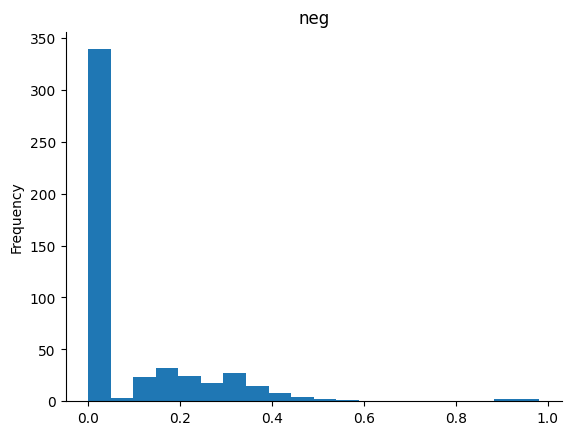

In [ ]:
from matplotlib import pyplot as plt
scored_news['neg'].plot(kind='hist', bins=20, title='neg')
plt.gca().spines[['top', 'right',]].set_visible(False)

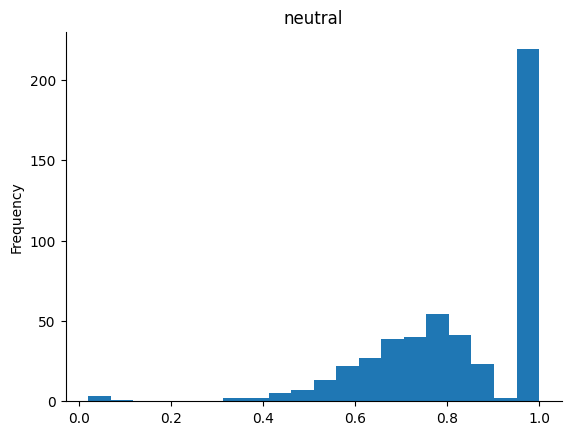

In [ ]:
from matplotlib import pyplot as plt
scored_news['neu'].plot(kind='hist', bins=20, title='neutral')
plt.gca().spines[['top', 'right',]].set_visible(False)

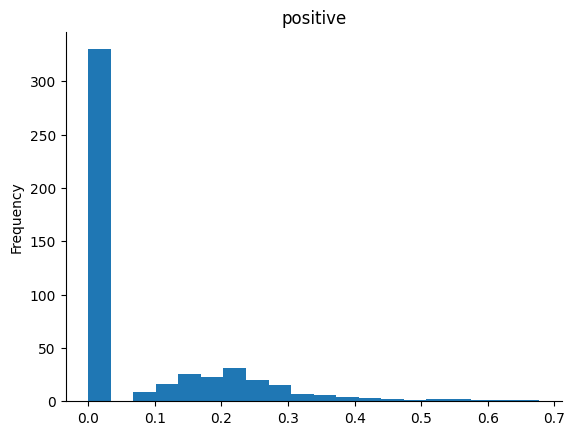

In [ ]:
from matplotlib import pyplot as plt
scored_news['pos'].plot(kind='hist', bins=20, title='positive')
plt.gca().spines[['top', 'right',]].set_visible(False)

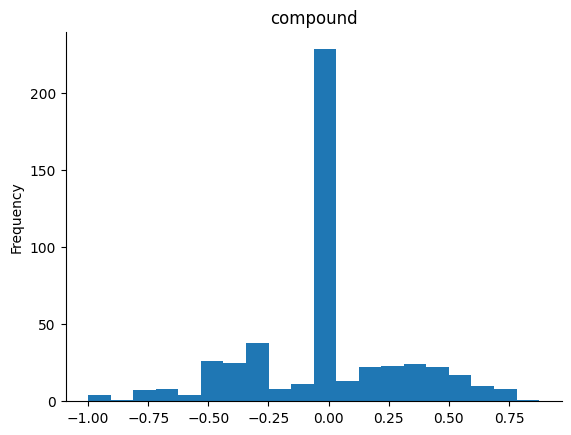

In [ ]:
from matplotlib import pyplot as plt
scored_news['compound'].plot(kind='hist', bins=20, title='compound')
plt.gca().spines[['top', 'right',]].set_visible(False)

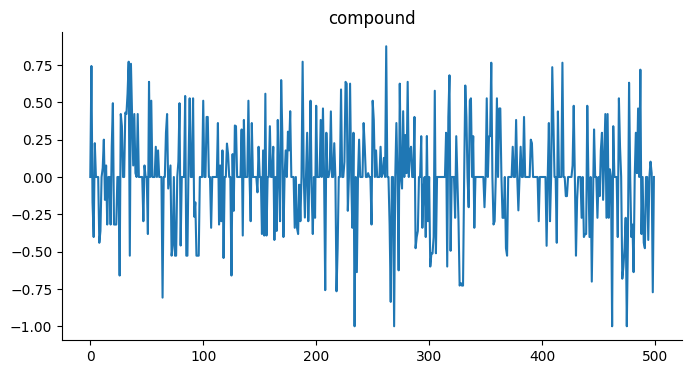

In [ ]:
# compound

from matplotlib import pyplot as plt
scored_news['compound'].plot(kind='line', figsize=(8, 4), title='compound')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: xlabel='date', ylabel='compound'>

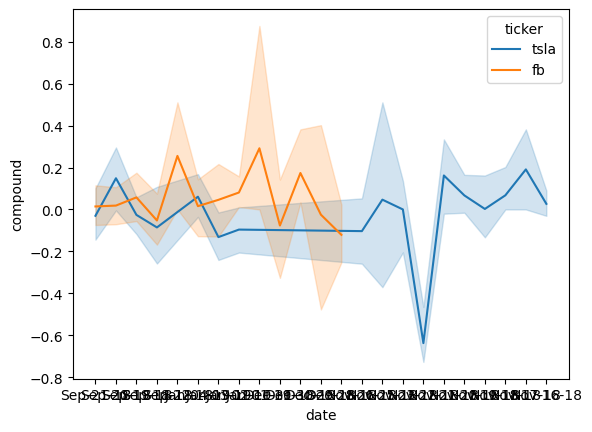

In [ ]:
# Average Sentiment Compound Score over Time

sns.lineplot(data=scored_news, x='date', y='compound', hue='ticker')

<Axes: xlabel='compound', ylabel='Count'>

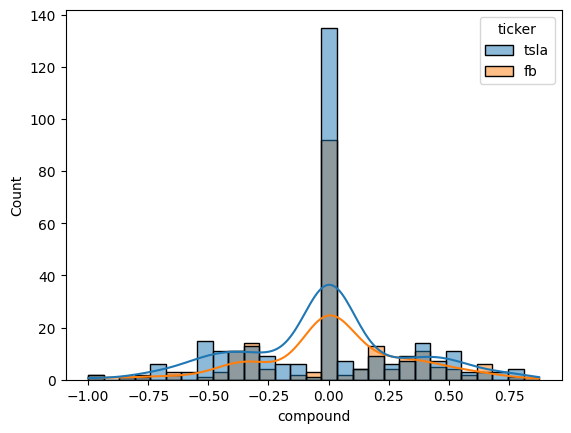

In [ ]:
# Sentiment Distribution by Stock

sns.histplot(data=scored_news, x="compound", hue="ticker", kde=True)

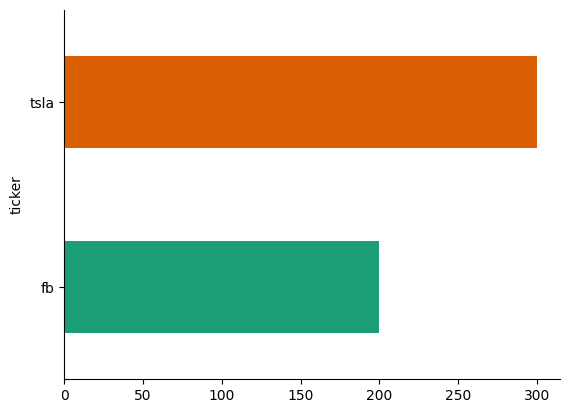

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
scored_news.groupby('ticker').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

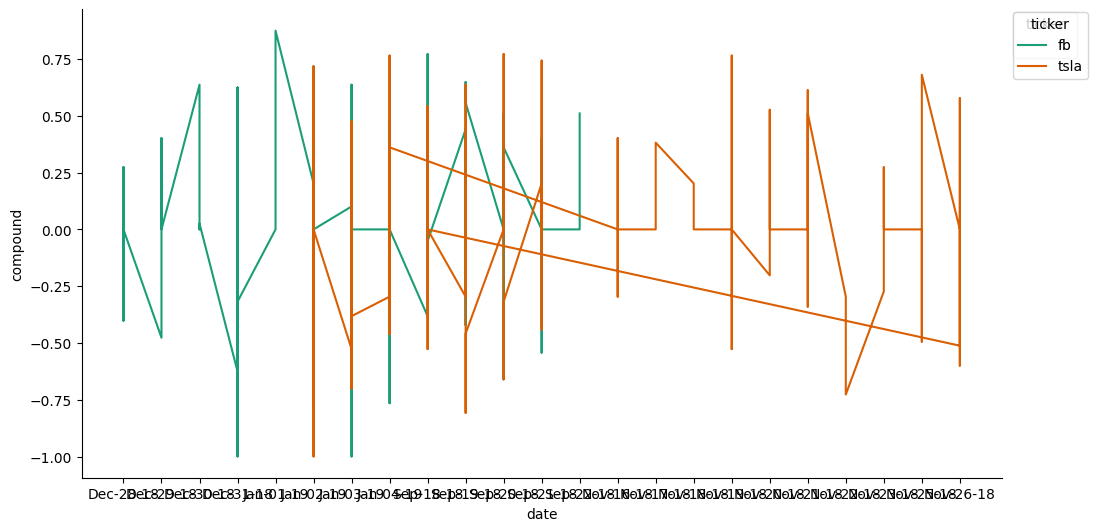

In [ ]:
# date vs compound

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['compound']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = scored_news.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ticker')):
  _plot_series(series, series_name, i)
  fig.legend(title='ticker', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('compound')

In [ ]:
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(['ticker', 'headline'])

In [ ]:
# Save cleaned data to CSV
scored_news_clean.to_csv('/content/scored_news_clean.csv', index=False)

In [ ]:
scored_news_clean

,ticker,date,time,headline,neg,neu,pos,compound
0,tsla,Sep-21-18,09:56PM,Billionaire investor questions Elon Musk getti...,0.000,1.000,0.000,0.0000
1,tsla,Sep-21-18,09:30PM,Broadcoms Stock Looks Like a Winner,0.000,0.323,0.677,0.7430
2,tsla,Sep-21-18,05:30PM,SHAREHOLDER ALERT: Pomerantz Law Firm Reminds...,0.167,0.726,0.107,-0.1697
3,tsla,Sep-21-18,05:30PM,Tesla's People Problem and the Inscrutable Mus...,0.184,0.816,0.000,-0.4019
4,tsla,Sep-21-18,05:03PM,Tesla Model 3 Crash Test Rating 2018: It Earns...,0.166,0.552,0.282,0.2263
...,...,...,...,...,...,...,...,...
494,tsla,Jan-02-19,09:26AM,"Tesla's stock tumbles after deliveries miss, p...",0.388,0.612,0.000,-0.4215
496,tsla,Jan-02-19,09:13AM,"Tesla cuts prices on all models by $2,000 to o...",0.124,0.730,0.146,0.1027
497,tsla,Jan-02-19,09:08AM,"Tesla shares dive after price cut, production ...",0.204,0.583,0.214,0.0258
498,tsla,Jan-02-19,08:56AM,Hedge fund all-star David Einhorn posts his wo...,0.358,0.642,0.000,-0.7717
